In [1]:
import pandas as pd
import numpy as np
import torch
data = pd.read_csv('DATA3_filter.csv')

In [2]:
ctrl_o2 = data["3UD5NAO032"] #省煤器出口氧量
ctrl_coal = data[["3U28M04AFT", "3U28M04BFT", "3U28M04CFT", "3U28M04DFT"]] #给煤机给煤量
ctrl_sec = data[["3U71MCV07AK", "3U71MCV07BK", "3U71MCV07CK", "3U71MCV07DK"]] #二次风门开度
ctrl_sofa = data[["3USOFABJ1ZT"]] #燃尽风门开度

In [3]:
state_all = data[["MW", "3UCCSPT", "3U03TEA", "3UZQFT", "3U05TE01", "3U06PT04", "3U80FT04", "3U80FT05", "3UTAFF", "3U72PT04", "3UBCFHHTL"]]  # 状态变量
target_etem = (data["3U78TE02A"] + data["3U78TE02B"]) / 2  # 排烟温度
target_co = data["co_filter"]  # CO浓度
target_nox = data["nox_filter"]  # NOx浓度
target_eff = data["eff"]  # 锅炉热效率
load = data["MW"]  # 机组负荷

# 变量的描述信息

In [4]:
#数据分布
def print_distribution(data, points=[0.1,1,2,3,97,98,99,99.9]):
    for point in points:
        print(f"分位数{point}:",np.percentile(data, point))
    data_inc = (np.roll(data, -1) - data)[:-1]
    for point in points:
        print(f"增量分位数{point}:",np.percentile(data_inc, point))

print_distribution(np.array(target_nox), points=[0.1,99.9])

分位数0.1: 485.5502976
分位数99.9: 3398.7802280000033
增量分位数0.1: -10.0
增量分位数99.9: 10.0


In [5]:
state_all.max()

MW           272.190
3UCCSPT       16.846
3U03TEA      549.848
3UZQFT       821.677
3U05TE01     537.183
3U06PT04       3.167
3U80FT04      21.746
3U80FT05       3.362
3UTAFF       246.092
3U72PT04       3.807
3UBCFHHTL     14.998
dtype: float64

In [6]:
state_all.min()

MW           125.911
3UCCSPT       12.744
3U03TEA      505.195
3UZQFT       398.288
3U05TE01     504.741
3U06PT04       1.560
3U80FT04       1.263
3U80FT05       0.000
3UTAFF       111.789
3U72PT04       0.000
3UBCFHHTL      0.026
dtype: float64

In [7]:
#定义数据上下限
ctrl_o2_limit = [[4], [8]]
ctrl_coal_limit = [[0, 0, 0, 0], [80, 80, 80, 80]]
ctrl_sec_limit = [[0, 0, 0, 0], [100, 100, 100, 100]]
ctrl_sofa_limit = [[0], [100]]
state_all_limit = [[125, 12, 505, 398, 504, 0, 0, 0, 110, 0, 0], [274, 18, 550, 822, 538, 4, 22, 4, 248, 4, 15]]
target_etem_limit = [[109], [139]]
target_co_limit = [[18], [514]]
target_nox_limit = [[485], [3400]]

In [8]:
# 确保 reshape 正确
def shape2d(data):
    data = np.array(data)
    if len(data.shape) == 1:
        return data.reshape(-1, 1)
    return data

In [9]:
# 归一化函数
def minMaxNormalize(data, min_value, max_value):
    return (data - min_value) / (max_value - min_value)

In [10]:
# 准备数据
data_ctrl = np.concatenate([shape2d(ctrl_o2), shape2d(ctrl_coal), shape2d(ctrl_sec), shape2d(ctrl_sofa)], axis=1)
data_state = shape2d(state_all)
data_target = np.concatenate([shape2d(target_etem), shape2d(target_co), shape2d(target_nox)], axis=1)

In [11]:
data_ctrl_limit = np.concatenate([shape2d(ctrl_o2_limit), shape2d(ctrl_coal_limit), shape2d(ctrl_sec_limit), shape2d(ctrl_sofa_limit)], axis=1)
data_state_limit = shape2d(state_all_limit)
data_target_limit = np.concatenate([shape2d(target_etem_limit), shape2d(target_co_limit), shape2d(target_nox_limit)], axis=1)

In [12]:
# 打印形状以进行调试
print("data_ctrl 的形状:", data_ctrl.shape)
print("data_ctrl_limit 的形状:", data_ctrl_limit.shape)
print("data_state 的形状:", data_state.shape)
print("data_state_limit 的形状:", data_state_limit.shape)
print("data_target 的形状:", data_target.shape)
print("data_target_limit 的形状:", data_target_limit.shape)

data_ctrl 的形状: (54219, 10)
data_ctrl_limit 的形状: (2, 10)
data_state 的形状: (54219, 11)
data_state_limit 的形状: (2, 11)
data_target 的形状: (54219, 3)
data_target_limit 的形状: (2, 3)


In [13]:
# 检查形状是否匹配
assert data_ctrl.shape[1] == data_ctrl_limit.shape[1], "控制数据和限制特征数量不匹配"
assert data_state.shape[1] == data_state_limit.shape[1], "状态数据和限制特征数量不匹配"
assert data_target.shape[1] == data_target_limit.shape[1], "目标数据和限制特征数量不匹配"

In [14]:
# 归一化
data_ctrl = minMaxNormalize(data_ctrl, data_ctrl_limit[0, :], data_ctrl_limit[1, :])
data_state = minMaxNormalize(data_state, data_state_limit[0, :], data_state_limit[1, :])
data_target = minMaxNormalize(data_target, data_target_limit[0, :], data_target_limit[1, :])

# 建立预测模型

## LSTM

### 1. 数据预处理

In [15]:
# 定义数据预处理函数，将时间序列切分成适合LSTM的数据块
def create_sequences(data, n_steps):
    sequences = []
    targets = []
    for i in range(len(data) - n_steps):
        # 取 `n_steps` 个时间步的输入作为序列
        sequences.append(data[i:i + n_steps, :-1])
        # 将第 n_steps 时间步之后的数据作为目标
        targets.append(data[i + n_steps, -1:])
    return np.array(sequences), np.array(targets)

In [16]:
# 设置时间步长（例如5）
n_steps = 5

In [17]:
# 将输入数据和目标数据结合
data_combined = np.concatenate([data_ctrl, data_state, data_target], axis=1)

In [18]:
# 生成LSTM的输入序列和目标
X, y = create_sequences(data_combined, n_steps)

In [19]:
# 转换为tensor
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

### 2. 创建 LSTM 数据集和数据加载器

In [20]:
from torch.utils.data import Dataset, DataLoader

In [21]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [22]:
# 创建数据集和数据加载器
dataset = TimeSeriesDataset(X, y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

### 3. 定义 LSTM 模型

In [23]:
import torch.nn as nn

In [24]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 定义LSTM层
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # 定义全连接层，用于输出
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # LSTM输出
        out, _ = self.lstm(x, (h0, c0))
        
        # 取最后一个时间步的输出
        out = self.fc(out[:, -1, :])
        return out

In [25]:
# 设置模型参数
input_size = X.shape[2]  # 特征数量
hidden_size = 64
output_size = y.shape[1]  # 输出大小
num_layers = 2

In [26]:
model = LSTMModel(input_size, hidden_size, output_size, num_layers)

### 4. 设置损失函数和优化器

In [27]:
import torch.optim as optim
import mpmath
import sympy

In [28]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### 5. 训练模型

In [29]:
# 将模型移动到设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
X, y = X.to(device), y.to(device)

In [30]:
num_epochs = 50
train_losses = []
model.train()

LSTMModel(
  (lstm): LSTM(23, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [31]:
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for i, (seqs, targets) in enumerate(dataloader):
        # 将数据传入设备
        seqs, targets = seqs.to(device), targets.to(device)
        
        # 前向传播
        outputs = model(seqs)
        loss = criterion(outputs, targets)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # 平均损失
    avg_loss = epoch_loss / len(dataloader)
    train_losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

Epoch [10/50], Loss: 0.0011
Epoch [20/50], Loss: 0.0005
Epoch [30/50], Loss: 0.0004
Epoch [40/50], Loss: 0.0002
Epoch [50/50], Loss: 0.0003


### 6. 进行预测

In [32]:
model.eval()
with torch.no_grad():
    predictions = model(X).cpu().numpy()
    actuals = y.cpu().numpy()

print(predictions)

[[0.04030179]
 [0.03959717]
 [0.03890911]
 ...
 [0.07467459]
 [0.07676686]
 [0.07575558]]


### 7. 可视化结果

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

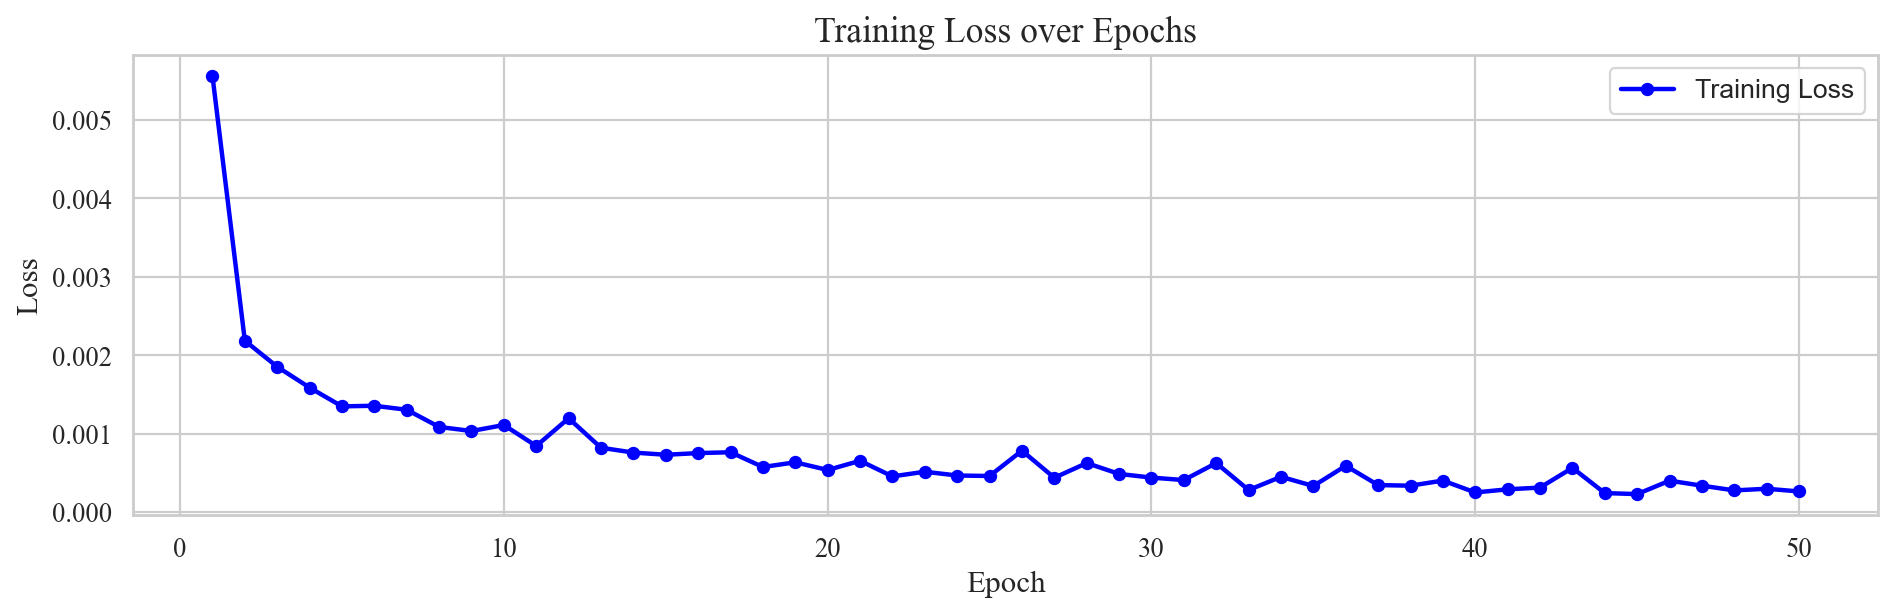

In [68]:
# 可视化训练损失
sns.set(style="whitegrid")
plt.figure(figsize=(12, 4), dpi=160)
plt.plot(range(1, num_epochs + 1), train_losses, color='blue', linestyle='-', linewidth=2, marker='o', markersize=5, label="Training Loss")

plt.xlabel("Epoch", fontsize=14, family='Times New Roman')
plt.ylabel("Loss", fontsize=14, family='Times New Roman')
plt.title("Training Loss over Epochs", fontsize=16, family='Times New Roman')
plt.grid(True)

plt.xticks(fontsize=12, family='Times New Roman')
plt.yticks(fontsize=12, family='Times New Roman')

plt.legend(frameon=True, loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()

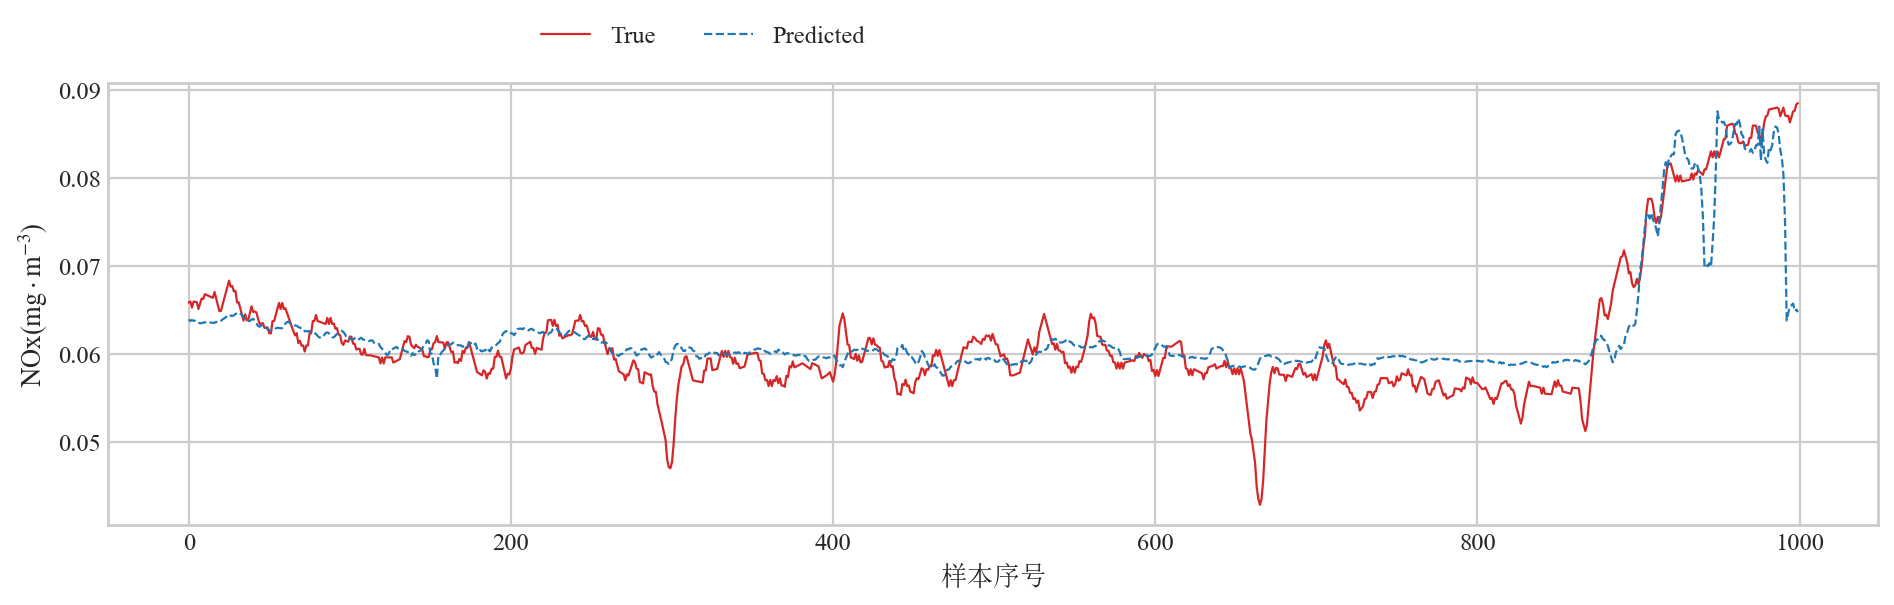

In [85]:
y_true = y.cpu().numpy()       # 将真实值从 tensor 转换为 numpy 数组
y_pred = predictions           # 直接使用之前预测生成的 numpy 数组

fontsize = 12
config = {
    "font.family": 'serif',
    "font.size": fontsize,
    "mathtext.fontset": 'stix',
    "xtick.direction": "in",
    "ytick.direction": "in",
    "font.family": "times new roman",
}
rcParams.update(config)

color_list = plt.cm.tab10(np.linspace(0, 1, 12))
plt.figure(dpi=160, figsize=(12, 4))

# 设置绘制区间
st = 4500
ed = 5500
time_step = 0  # 假设绘制第一个时间步的数据

# 绘制真实值曲线
plt.plot(np.arange(ed - st), y_true[st:ed, time_step],  
         color=color_list[4], 
         linestyle='-', 
         linewidth=1, 
         label="True")

# 绘制预测值曲线
plt.plot(np.arange(ed - st), y_pred[st:ed, time_step], 
         color=color_list[1], 
         linestyle='--', 
         linewidth=1, 
         label="Predicted")

plt.xlabel("样本序号", size=fontsize, family='SimSun')
plt.ylabel("NOx($\mathrm{mg \cdot m^{-3}}$)", {"size": 12})

legend_font = {"family": "times new roman", "size": 11}
plt.legend(['True', 'Predicted'], frameon=False, prop=legend_font, ncol=2, bbox_to_anchor=(0.44, 1.18))

plt.tight_layout()
plt.show()